In [1]:
!gdown https://drive.google.com/uc?id=1LQXGTRB174vrRbcBKSqrGA_XReSbIm_1
!unzip template-matching.zip

Downloading...
From: https://drive.google.com/uc?id=1LQXGTRB174vrRbcBKSqrGA_XReSbIm_1
To: /content/template-matching.zip
100% 682k/682k [00:00<00:00, 10.8MB/s]
Archive:  template-matching.zip
  inflating: template-matching/image1.jpg  
  inflating: template-matching/image2.jpg  
  inflating: template-matching/image3.jpg  
  inflating: template-matching/image4.jpg  
  inflating: template-matching/image5.jpg  
  inflating: template-matching/image6.jpg  
  inflating: template-matching/image7.jpg  
  inflating: template-matching/image8.jpg  
  inflating: template-matching/imagenet1000_clsid_to_human.pkl  
  inflating: template-matching/template.jpg  
  inflating: template-matching/template_cat1.jpg  


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import math
from scipy.ndimage.filters import generic_filter
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.vgg16 import preprocess_input
from matplotlib import patches

In [3]:
# get model
model_height = 224
model_width = 224
model = tf.keras.applications.VGG16(include_top=True, weights='imagenet', input_shape=(model_height, model_width, 3))

553467904/553467096 [==============================] - 3s 0us/step


(550, 1500)


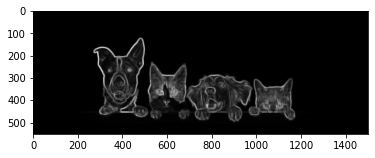

In [7]:
PATH = '/content/template-matching/'
height = 550
width = 1500

img  = cv2.imread(PATH + 'image7.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, (width, height))
gray = gray.astype('float')
gray_std = generic_filter(gray, np.std, size=7)
gray_std = gray_std * 2.6

plt.figure(figsize=(6, 6))
plt.imshow(gray_std, cmap='gray')
print(gray_std.shape)

In [9]:
# compute features
image_np = kimage.img_to_array(kimage.load_img(PATH + 'image7.jpg', target_size=(height, width)))
image_np = np.expand_dims(image_np, axis=0)

100%|██████████| 327/327 [00:13<00:00, 24.18it/s]

count= 19272


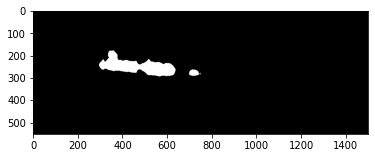

In [16]:
### Test ###
count = 0
map = np.zeros_like(gray_std)
for i in tqdm(range(height-model_height+1)):
  for j in range(width-model_width+1):
    flag = gray_std[i:i+model_height, j:j+model_width]
    flag = np.sum(flag) / (model_height * model_width)
    if (flag > 45):
      count = count + 1
      map[i,j] = 1

print('count=', count)
plt.figure(figsize=(6,6))
plt.imshow(map, cmap='gray')

In [20]:
# compute predictions ~ 30mins
prediction_data = []
for i in tqdm(range(height-model_height+1)):
  for j in range(width-model_width+1):
    flag = gray_std[i:i+model_height, j:j+model_width]
    flag = np.sum(flag) / (model_height*model_width*1.0)
    if (flag > 45.0):
      patch = image_np[:, i:i+model_height, j:j+model_width, :]
      patch = preprocess_input(patch)
      patch = model.predict(patch)
      prediction_data.append((patch[0].max(), i, j, patch[0].argmax()))

100%|██████████| 327/327 [14:35<00:00,  2.68s/it]


In [22]:
tp_sorted = sorted(prediction_data, key=lambda item: item[0], reverse=True)

In [26]:
labels = np.load(PATH+'imagenet1000_clsid_to_human.pkl', allow_pickle=True)

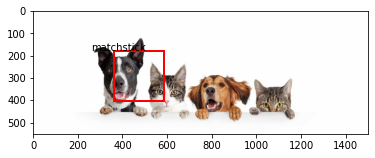

In [29]:
im = kimage.load_img(PATH + 'image7.jpg', target_size=(height, width))

fig, ax = plt.subplots()
ax.imshow(im)

# Create a Rectangle patch
for i in range(1): 
  rect = patches.Rectangle((tp_sorted[i][2], tp_sorted[i][1]), model_height, model_width, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.text(tp_sorted[i][2]-100, tp_sorted[i][1], labels[tp_sorted[i][3]])

plt.show()